# Vertex Model Grid (DISV) plotting

No problem! Flopy supports vertex model grid plotting through the `PlotMapView` and `PlotCrossSection` classes. 

The method calls are almost identical to models that use a Structured Model Grid (DIS) to define the model discretization. Let's run through an example using a vertex model grid.

First let's import flopy and get the model loaded!

In [1]:
%matplotlib inline
import flopy as fp
from flopy.plot import PlotMapView
from flopy.utils import HeadFile, CellBudgetFile
import matplotlib.pyplot as plt
import numpy as np
import os

# load up the example problem
sim_name = "mfsim.nam"
sim_path = "../data/mf6/test003_gwfs_disv"
sim = fp.mf6.MFSimulation.load(sim_name=sim_name, version="mf6", exe_name="mf6",
                               sim_ws=sim_path)

Directory structure already exists for simulation path /Users/jlarsen/Desktop/flopy-ogw/flopy/examples/Notebooks/../data/mf6/test003_gwfs_disv
loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package disv...
    loading package ic...
    loading package npf...
    loading package chd...
    loading package chd...
    loading package oc...
  loading ims package gwf_1...


Now let's check the model name and then get an instance of our model

In [2]:
sim.model_names

odict_keys(['gwf_1'])

In [3]:
ml = sim.get_model('gwf_1')
ml

name = gwf_1
model_type = gwf
version = mf6
model_relative_path = 

###################
Package disv
###################

package_name = disv
filename = model.disv
package_type = disv
model_or_simulation_package = model
model_name = gwf_1


###################
Package ic
###################

package_name = ic
filename = model.ic
package_type = ic
model_or_simulation_package = model
model_name = gwf_1


###################
Package npf
###################

package_name = npf
filename = model.npf
package_type = npf
model_or_simulation_package = model
model_name = gwf_1


###################
Package chd_left
###################

package_name = chd_left
filename = model_left.chd
package_type = chd
model_or_simulation_package = model
model_name = gwf_1


###################
Package chd_right
###################

package_name = chd_right
filename = model_right.chd
package_type = chd
model_or_simulation_package = model
model_name = gwf_1


###################
Package oc
###################

pa

## Build a vertex model grid object
The `VertexModelGrid` in not yet integrated into FloPy, but will be shortly. Until then we can build a `VertexModelGrid` instance to use for plotting

In [4]:
from flopy.proposed_grid.proposed_vertex_mg import VertexModelGrid

vmg = VertexModelGrid(ml.dis.vertices, ml.dis.cell2d,
                      top=ml.dis.top, botm=ml.dis.botm,
                      idomain=ml.dis.idomain.array, xoffset=10,
                      yoffset=0, rotation=-25)
vmg

Now all the discretization information is available to be used to plot model data in a `PlotMapView` or `PlotCrossSection` object

Let's begin with `PlotMapView` and plot the model grid.

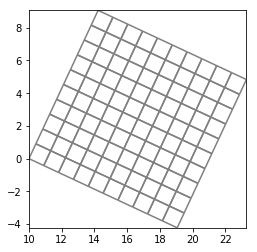

In [5]:
map = PlotMapView(modelgrid=vmg, layer=0)
ax = map.plot_grid()

As we can see, the model grid plots as a series of grid lines.

We can also plot inactive cells using `plot_inactive`

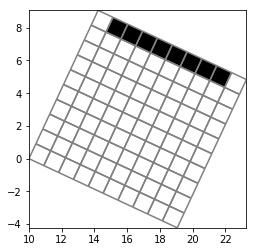

In [6]:
map = PlotMapView(modelgrid=vmg, layer=0)
ax = map.plot_inactive()
map.plot_grid()

Model data can be plotted using the `plot_array` method as follows:

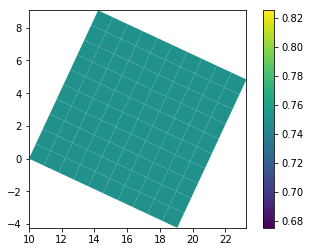

In [7]:
map = PlotMapView(modelgrid=vmg, layer=0)
ax = map.plot_array(a=ml.dis.botm.array)
plt.colorbar(ax)

This plot is not very exciting. We see that the bottom elevation is a constant 0.75. 

Let's import some data from the model output to use with `plot_array()` to illustrate plotting better.

In [8]:
hds_file = os.path.join(sim_path, "expected_output/", "model_unch.hds")
cbc_file = os.path.join(sim_path, "expected_output/", "model_unch.cbc")

hds = HeadFile(hds_file)
hdata = hds.get_alldata()[0]
hdata.shape = (4, -1)

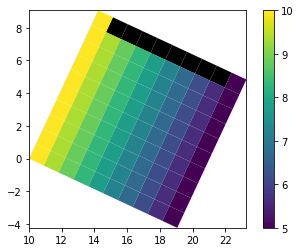

In [9]:
map = PlotMapView(modelgrid=vmg, layer=0)
ax = map.plot_inactive()
ax = map.plot_array(a=hdata.ravel(), masked_values=[1e30])
plt.colorbar(ax)

Data can also be contoured using the `contour_array` method.

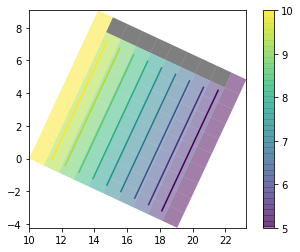

In [10]:
map = PlotMapView(modelgrid=vmg, layer=0)
ax = map.plot_inactive(alpha=0.5)
ax = map.plot_array(a=hdata[0], masked_values=[1e30], alpha=0.5)
levels = np.arange(5, 10, 0.5)
map.contour_array(a=hdata[0], masked_values=[1e30], levels=levels)
plt.colorbar(ax)

### Plotting specific discharge

This method is slightly different than the structured grid methodology.

1st we need to get the flow ja face output from the binary cell by cell output file

In [11]:
cbc = CellBudgetFile(cbc_file, precision='double')
fja = cbc.get_data(text="FLOW JA FACE")
fja

[array([[[ 0.00000000e+00,  0.00000000e+00, -3.82603469e-01, ...,
          -1.16054538e-01,  6.22056559e-07,  1.16053916e-01]]])]

Now we can pass the flow ja face array to `plot_discharge`; FloPy will automatically make the flow connections and vectorize the flow for us.

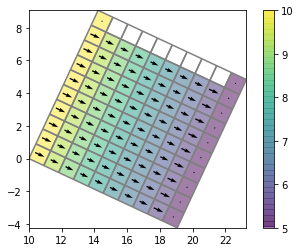

In [12]:
map = PlotMapView(modelgrid=vmg, layer=0)
ax = map.plot_grid()
ax = map.plot_array(a=hdata, alpha=0.5, masked_values=[1e30])
plt.colorbar(ax)
ax = map.plot_discharge(fja=fja, head=hdata, dis=ml.dis)
